In [1]:

import os
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mutual_info_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

# Load Data

In [2]:
# Load Data
df = pl.read_csv("../DATASET/heart.csv")

In [3]:
# Shape
df.shape

(918, 12)

In [4]:
# Check nulls
df.null_count()

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# check duplicates
df.is_duplicated().unique()

""
bool
false


# Mutual info score

In [6]:
df_target = df['HeartDisease']

def calculate_mi(series):
    return mutual_info_score(series, df_target)

df_mi = pl.DataFrame({
    col: calculate_mi(df[col])
    for col in ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
}).transpose(include_header=True)

df_mi

column,column_0
str,f64
"""Age""",0.073583
"""RestingBP""",0.062498
"""Cholesterol""",0.223062
"""MaxHR""",0.161544
"""Oldpeak""",0.145127


# Preprocessing

In [7]:
# Encoder
le = LabelEncoder()
dv = DictVectorizer()

In [8]:
df = df.with_columns(
    Sex = le.fit_transform(df['Sex']),
    ChestPainType = le.fit_transform(df['ChestPainType']),
    RestingECG = le.fit_transform(df['RestingECG']),
    ExerciseAngina = le.fit_transform(df['ExerciseAngina']),
    ST_Slope = le.fit_transform(df['ST_Slope'])
)

In [9]:
# Split data
df_train_full, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

In [10]:
# Scaler
scaler = MinMaxScaler()

In [11]:
len(df), len(df_train), len(df_test), len(df_val)

(918, 550, 184, 184)

In [12]:
# Train
x_train = df_train.select(pl.exclude("HeartDisease"))
x_train = scaler.fit_transform(x_train) # Applying MinMaxScaler
x_train = pl.DataFrame(x_train, schema=df.select(pl.exclude("HeartDisease")).columns)
x_train = x_train.to_dicts()
x_train = dv.fit_transform(x_train)
x_train = csr_matrix(x_train)
y_train = df_train['HeartDisease']

In [13]:
# Validation
x_val = df_val.select(pl.exclude("HeartDisease"))
x_val = scaler.transform(x_val) # Applying MinMaxScaler
x_val = pl.DataFrame(x_val, schema=df.select(pl.exclude("HeartDisease")).columns)
x_val = x_val.to_dicts()
x_val = dv.transform(x_val)
x_val = csr_matrix(x_val)
y_val = df_val['HeartDisease']

In [14]:
# Test
x_test = df_test.select(pl.exclude("HeartDisease"))
x_test = scaler.transform(x_test) # Applying MinMaxScaler
x_test = pl.DataFrame(x_test, schema=df.select(pl.exclude("HeartDisease")).columns)
x_test = x_test.to_dicts()
x_test = dv.transform(x_test)
x_test = csr_matrix(x_test)
y_test = df_test['HeartDisease']

# Train models

## Logistic Regression

In [15]:
# Model
lr_model = LogisticRegression(random_state=42, solver='newton-cholesky')

In [16]:
lr_model.fit(x_train, y_train)

LogisticRegression(random_state=42, solver='newton-cholesky')

In [17]:
# Test predict
y_pred_test = lr_model.predict(x_test)
y_pred_val = lr_model.predict(x_val)

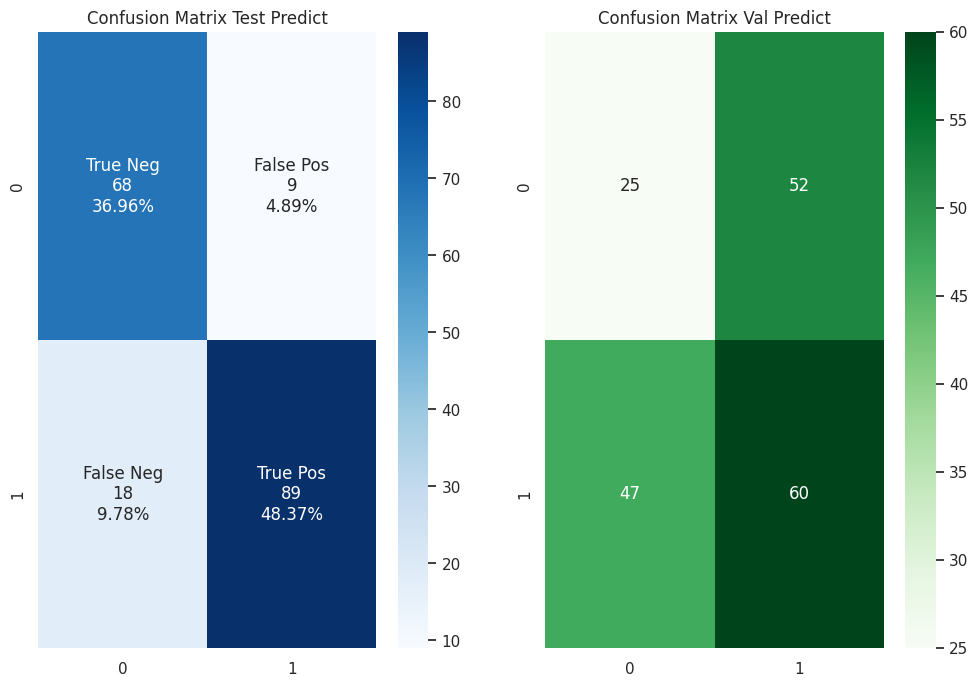

In [18]:
# confusion matrix
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
cf_matrix_test = confusion_matrix(y_test, y_pred_test)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_test.flatten()/np.sum(cf_matrix_test)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

g = sns.heatmap(cf_matrix_test, annot=labels, fmt="", cmap='Blues', ax=ax[0])
g.set(title="Confusion Matrix Test Predict")
h = sns.heatmap(confusion_matrix(y_test, y_pred_val), annot=True, cmap='Greens', ax=ax[1])
h.set(title="Confusion Matrix Val Predict")
plt.show()

In [19]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        77
           1       0.91      0.83      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



In [20]:
print(classification_report(y_test, y_pred_val))

              precision    recall  f1-score   support

           0       0.35      0.32      0.34        77
           1       0.54      0.56      0.55       107

    accuracy                           0.46       184
   macro avg       0.44      0.44      0.44       184
weighted avg       0.46      0.46      0.46       184



In [21]:
# RMSE
root_mean_squared_error(y_test, y_pred_test), root_mean_squared_error(y_test, y_pred_val)

(np.float64(0.3830654388414369), np.float64(0.7335144703827386))

## DecisionTree

In [22]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [23]:
y2_pred_test = dt.predict(x_test)
y2_pred_val = dt.predict(x_val)

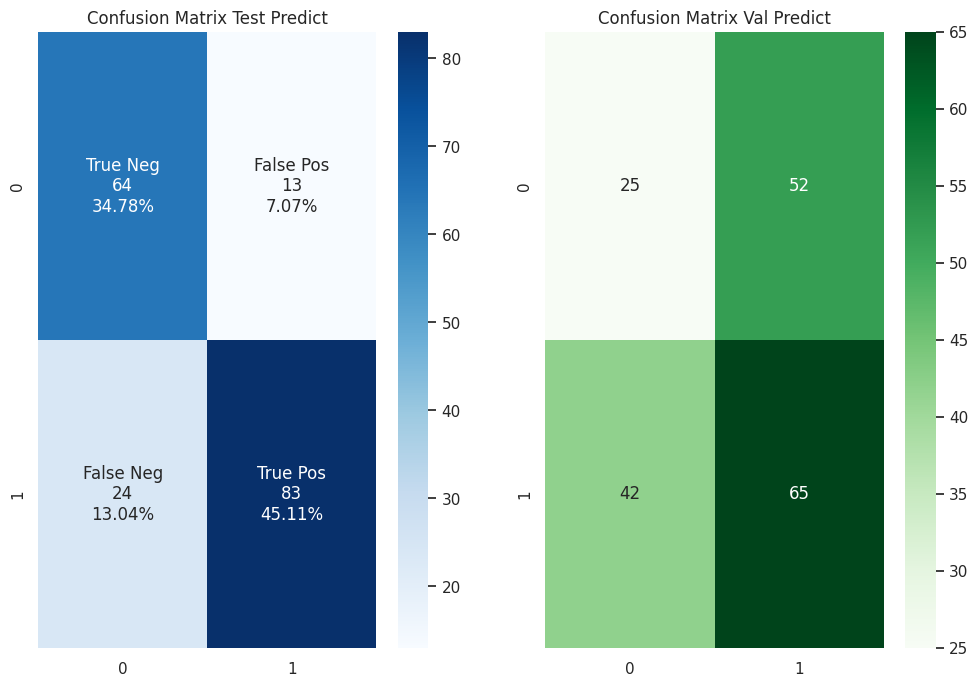

In [24]:
cf_matrix_dt_test = confusion_matrix(y_test, y2_pred_test)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_dt_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_dt_test.flatten()/np.sum(cf_matrix_dt_test)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

g = sns.heatmap(cf_matrix_dt_test, annot=labels, fmt="", cmap='Blues', ax=ax[0])
g.set(title="Confusion Matrix Test Predict")
h = sns.heatmap(confusion_matrix(y_test, y2_pred_val), annot=True, cmap='Greens', ax=ax[1])
h.set(title="Confusion Matrix Val Predict")
plt.show()

In [25]:
print(classification_report(y_test, y2_pred_test))

print(classification_report(y_test, y2_pred_val))

              precision    recall  f1-score   support

           0       0.73      0.83      0.78        77
           1       0.86      0.78      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184

              precision    recall  f1-score   support

           0       0.37      0.32      0.35        77
           1       0.56      0.61      0.58       107

    accuracy                           0.49       184
   macro avg       0.46      0.47      0.46       184
weighted avg       0.48      0.49      0.48       184



In [26]:
root_mean_squared_error(y_test, y2_pred_test), root_mean_squared_error(y_test, y2_pred_val)

(np.float64(0.44842720314644063), np.float64(0.7147514009901564))

## RandomForestClassifier

In [27]:
# RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(x_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=42)

In [28]:
y3_pred_test = rfc.predict(x_test)
y3_pred_val = rfc.predict(x_val)

In [29]:
print(classification_report(y_test, y3_pred_test))
print(classification_report(y_test, y3_pred_val))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        77
           1       0.89      0.85      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184

              precision    recall  f1-score   support

           0       0.36      0.34      0.35        77
           1       0.54      0.56      0.55       107

    accuracy                           0.47       184
   macro avg       0.45      0.45      0.45       184
weighted avg       0.46      0.47      0.47       184



In [30]:
root_mean_squared_error(y_test, y3_pred_test), root_mean_squared_error(y_test, y3_pred_val)

(np.float64(0.3830654388414369), np.float64(0.7298004491997617))

## Random Forest Regressor

In [31]:
# RandomForest
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=42, n_jobs=-1)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=42)

In [32]:
y4_pred_test = rfr.predict(x_test)
y4_pred_val = rfr.predict(x_val)

In [33]:
root_mean_squared_error(y_test, y4_pred_test), root_mean_squared_error(y_test, y4_pred_val)

(np.float64(0.3407153599733055), np.float64(0.6711443828333034))

# Model Scores

In [34]:
models = [lr_model, dt, rfc, rfr]
models_names = ["LogisticRegression", "DecisionTree", "RandomForestClassifier", "RandomForestRegressor"]

# Scores
train_score = [model.score(x_train, y_train) for model in models]
test_score = [model.score(x_test, y_test) for model in models]
val_score = [model.score(x_val, y_val) for model in models]

# Measure model state:6
rate = []
for train, test, val in zip(train_score, test_score, val_score):
    if train <= 0.65 and test <= 0.65 and val <= 0.65:
        rate.append('bad')
    elif (train > 0.65 and train < 0.80) and (test > 0.65 and test < 0.80) and (val > 0.65 and val < 0.80):
        rate.append('middle')
    elif (train >= 0.80 and test >= 0.80 and val >= 0.80) and (train <= 0.999 and test <= 0.999 and val <= 0.999):
        rate.append('good') 
    else:
        rate.append('overfite')  # Handle cases that don't fit the above

# Create DataFrame
model_score = pl.DataFrame({
    'Model': models_names,
    'Train score': [f'{round(score * 100, 2)}%' for score in train_score],
    'Test score': [f'{round(score * 100, 2)}%' for score in test_score],
    'Val score': [f'{round(score * 100, 2)}%' for score in val_score],
    'Evaluate model': rate
})

# Show result:
model_score

Model,Train score,Test score,Val score,Evaluate model
str,str,str,str,str
"""LogisticRegression""","""84.55%""","""85.33%""","""89.13%""","""good"""
"""DecisionTree""","""80.18%""","""79.89%""","""86.41%""","""overfite"""
"""RandomForestClassifier""","""99.64%""","""85.33%""","""89.67%""","""good"""
"""RandomForestRegressor""","""91.06%""","""52.3%""","""63.77%""","""overfite"""


# Saving models


In [35]:
def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)

In [36]:
for row in model_score.filter(pl.col("Evaluate model") == "good").iter_rows():
    print(row[0])

LogisticRegression
RandomForestClassifier


In [37]:
dest_path = '../models'

for row in tqdm(model_score.filter(pl.col("Evaluate model") == "good").iter_rows()):
        model_name = row[0]
        idx = models_names.index(model_name)
        model = models[idx]
        dump_pickle(model, os.path.join(dest_path, f"{model_name}.pkl"))

0it [00:00, ?it/s]

In [48]:
# Save enconder and scaler
dump_pickle(le, os.path.join(dest_path, "encoder.bin"))
dump_pickle(scaler, os.path.join(dest_path, "scaler.bin"))
dump_pickle(dv, os.path.join(dest_path, "dv.bin"))

# Test Model

In [49]:
import pickle as pkl
import json
# Load model
model_name = "LogisticRegression"
with open(f"../models/{model_name}.pkl", "rb") as f:
    model = pkl.load(f)
    
# Load Encoder
with open("../models/encoder.bin", "rb") as f:
    encoder = pkl.load(f)

# Load Scaler
with open("../models/scaler.bin", "rb") as f:
    scaler = pkl.load(f)
    
# Load DV
with open("../models/dv.bin", "rb") as f:
    dv = pkl.load(f)

In [50]:
model, encoder, scaler, dv

(LogisticRegression(random_state=42, solver='newton-cholesky'),
 LabelEncoder(),
 MinMaxScaler(),
 DictVectorizer())

In [41]:
with open('../heart_failure/test/sample.json', 'rt', encoding='utf-8') as f_in:
        data = json.load(f_in)
        
with open('../heart_failure/test/sample_1.json', 'rt', encoding='utf-8') as f_in:
        data2 = json.load(f_in)

In [42]:
data

{'Age': 40,
 'Sex': 'M',
 'ChestPainType': 'ATA',
 'RestingBP': 140,
 'Cholesterol': 289,
 'FastingBS': 0,
 'RestingECG': 'Normal',
 'MaxHR': 172,
 'ExerciseAngina': 'N',
 'Oldpeak': 0.0,
 'ST_Slope': 'Up'}

In [43]:
data2

{'Age': 49,
 'Sex': 'F',
 'ChestPainType': 'NAP',
 'RestingBP': 160,
 'Cholesterol': 180,
 'FastingBS': 0,
 'RestingECG': 'Normal',
 'MaxHR': 156,
 'ExerciseAngina': 'N',
 'Oldpeak': 1.0,
 'ST_Slope': 'Flat'}

In [89]:
def prepare_data(patient, encoder, scaler) -> pl.DataFrame:
    columns = patient.keys()
    patient = pl.DataFrame([patient])
    # Prepare
    patient = patient.with_columns(
        Sex = encoder.fit_transform(patient['Sex']),
        ChestPainType = encoder.fit_transform(patient['ChestPainType']),
        RestingECG = encoder.fit_transform(patient['RestingECG']),
        ExerciseAngina = encoder.fit_transform(patient['ExerciseAngina']),
        ST_Slope = encoder.fit_transform(patient['ST_Slope'])
    )
    # Scaler
    patient = scaler.fit_transform(patient) # Applying MinMaxScaler
    return pl.DataFrame(patient, schema=columns)

In [ ]:
def predict_single(patient, encoder, scaler, dv, model):
    X = prepare_data(patient, encoder, scaler)
    X = X.to_dicts()
    X = dv.transform(X)
    X = csr_matrix(X)
    y_pred = model.predict(X)[:, 1]
    return y_pred[0]

In [90]:
predict_single(patient=data, encoder=encoder, scaler=scaler, dv=dv, model=model)

array([1])